In [1]:
import pandas as pd

In [2]:
df = pd.read_csv('titanic_train.csv')
df.head()



,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
df_original = df.copy()

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [5]:
df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

### Found missing values for Age, Cabin and Embarked( with 2 missing values).

#### Filling the missing values of Age with mean is dumb. Assuming every missing value is of mean yrs old


In [8]:
# df['Age'].fillna(df['Age'].mean(), inplace = True)
# df['Age'].mean()

# 29.69911764705882


- So we find a feature that has some relation/affect on Age so that values of Age with respect to Values of that particular feature are different.

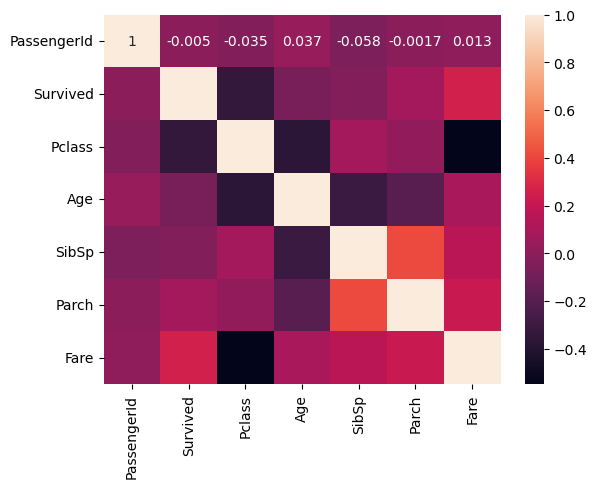

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(df.corr(numeric_only=True), annot=True)
plt.show()

#### Considering correlation between Age and other

In [12]:
print(df.corr(numeric_only=True)['Age'].sort_values(ascending=False))


Age            1.000000
Fare           0.096067
PassengerId    0.036847
Survived      -0.077221
Parch         -0.189119
SibSp         -0.308247
Pclass        -0.369226
Name: Age, dtype: float64


- After analysing the correlation, Pclass is more influential. So we groupby Pclass and repalce the missing values with the median value of each class.

In [14]:
df_Pclass = df_original.copy()

df_Pclass['Age'] = df_Pclass.groupby(['Pclass'])['Age'].transform(lambda x: x.fillna(x.median()))
df_Pclass['Age'].isnull().sum()


0

#### Using Sex attribute to group by and replace with median for each value of Pclass

In [16]:
df_encoded = df_original.copy()
df_encoded['Sex'] = df_encoded['Sex'].map({'male':0, 'female':1})
df_encoded['Sex'].head()


0    0
1    1
2    1
3    1
4    0
Name: Sex, dtype: int64

In [17]:
df_encoded.corr(numeric_only=True)['Age']

PassengerId    0.036847
Survived      -0.077221
Pclass        -0.369226
Sex           -0.093254
Age            1.000000
SibSp         -0.308247
Parch         -0.189119
Fare           0.096067
Name: Age, dtype: float64

- Though the correlation is weak, it adds meaningful context, so we group by both Pclass and Sex

In [19]:
df_encoded['Age'] = df.groupby(['Pclass', 'Sex'])['Age'].transform(lambda x: x.fillna(x.median()))

In [20]:
df_encoded['Age'].isnull().sum()

0

### Another accurate data centric approach is to impute the missing values using a ML regression model for predicting Age

In [72]:
df_model = df.copy()
df_model.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [74]:
df_model['Age'].isnull().sum()

177

- In our Model based imputation, we extract important features to feed into our model to predict Age, now we encode Age and Embarked as all other are alreadty numeric.

In [77]:
df_model['Sex'] = df_model['Sex'].map({'male':0, 'female':1})

df_model = pd.get_dummies(df_model, columns=['Embarked'], drop_first=True)
df_model[['Embarked_Q', 'Embarked_S']] = df_model[['Embarked_Q', 'Embarked_S']].astype(int)
# Embarked_C is dropped as in alphabetical order because of get_dummies() which is onehotencoding for categorical values

In [79]:
features = ['Pclass', 'Sex', 'SibSp', 'Parch', 'Fare', 'Embarked_Q', 'Embarked_S']

df_known_age = df_model[df_model['Age'].notnull()]
df_unknown_age = df_model[df_model['Age'].isnull()]

In [81]:
from sklearn.ensemble import RandomForestRegressor

X_train = df_known_age[features]

y_train = df_known_age['Age']

X_pred = df_unknown_age[features]

jod = RandomForestRegressor(n_estimators = 100, random_state = 42)

jod.fit(X_train, y_train)
y_pred = jod.predict(X_pred)

In [83]:
#filling out the missing values with the predicted age
df_model.loc[df_model['Age'].isnull(), 'Age'] = y_pred

In [85]:
df_model['Age'].isnull().sum()

0

-  After multiple imputation strategies, model based imputation is accurate as this method captures relationship with other features like:<br/>
features = ['Pclass', 'Sex', 'SibSp', 'Parch', 'Fare', 'Embarked_Q', 'Embarked_S'].
-  Simpler methods also exist such as group based median imputation which are quick but rely on few relations.


In [88]:
df_model.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked_Q,Embarked_S
0,1,0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.2500,NaN,0,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71.2833,C85,0,0
2,3,1,3,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,7.9250,NaN,0,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,113803,53.1000,C123,0,1
4,5,0,3,"Allen, Mr. William Henry",0,35.0,0,0,373450,8.0500,NaN,0,1


Feature Engineering:
- family and solo travellers to check if solo travellers had a better chance of survival

In [90]:
# total people a passenger is with(family)
df_model['family'] = df['SibSp'] + df['Parch'] + 1
# solo passengers
df_model['solo'] = 0
df_model.loc[df_model['family']==1, 'solo']=1

In [92]:
df_model.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked_Q,Embarked_S,family,solo
0,1,0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.2500,NaN,0,1,2,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71.2833,C85,0,0,2,0
2,3,1,3,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,7.9250,NaN,0,1,1,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,113803,53.1000,C123,0,1,2,0
4,5,0,3,"Allen, Mr. William Henry",0,35.0,0,0,373450,8.0500,NaN,0,1,1,1


Dropping down irrelevant features.

In [95]:
df_model.drop(columns=['PassengerId', 'Name', 'Ticket', 'Cabin'], inplace=True)

In [113]:
df_model_backup = df_model.copy()

In [115]:
df_model.head()


,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked_Q,Embarked_S,family,solo
0,0,3,0,22.0,1,0,7.2500,0,1,2,0
1,1,1,1,38.0,1,0,71.2833,0,0,2,0
2,1,3,1,26.0,0,0,7.9250,0,1,1,1
3,1,1,1,35.0,1,0,53.1000,0,1,2,0
4,0,3,0,35.0,0,0,8.0500,0,1,1,1


In [99]:
X_real = df_model.drop(['Survived'], axis=1)
y_real = df_model['Survived']

In [109]:
print(X_real.shape,y_real.shape)

(891, 10) (891,)
